# Day Energy Model
Training a model on manually labelled EEG data to find various states.

In [6]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter
log = lambda msg: logging.info(msg)


# Load data

In [7]:
input_dir = "C:\\dev\\play\\brainwave-data-day"
stats_df = pd.read_csv(input_dir + os.path.sep + "day_stats.csv")


In [8]:
from models.eeg_states.eeg_states import load_and_prepare_day_data_energy_eeg_state_events

events = load_and_prepare_day_data_energy_eeg_state_events()

C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-11-15 09:34:49.320000+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  events.at[i, 'since'] = since_time
C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:117: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  events['duration'] = events['timestamp'] - events['since']


In [9]:
events

,version,phase,event,note,duration,TimestampUK,SinceUK,dayAndNightOf
0,v1,day,tired_long,NaN,0 days 00:05:00,2024-11-15 09:39:49.320000+00:00,2024-11-15 09:34:49.320000+00:00,2024-11-15
1,v1,day,tired_long,NaN,0 days 00:02:50.530000,2024-11-15 09:42:39.850000+00:00,2024-11-15 09:39:49.320000+00:00,2024-11-15
2,v1,day,tired_long,NaN,0 days 00:01:14.072000,2024-11-15 09:43:53.922000+00:00,2024-11-15 09:42:39.850000+00:00,2024-11-15
3,v1,day,tired_long,NaN,0 days 00:03:34.874000,2024-11-15 09:47:28.796000+00:00,2024-11-15 09:43:53.922000+00:00,2024-11-15
4,v1,day,tired_long,NaN,0 days 00:03:59.597000,2024-11-15 09:51:28.393000+00:00,2024-11-15 09:47:28.796000+00:00,2024-11-15
...,...,...,...,...,...,...,...,...
308,v1,day,tired,,NaT,2024-11-22 07:29:40.593000+00:00,NaT,2024-11-22
309,v1,day,tired,,NaT,2024-11-22 08:10:49.954000+00:00,NaT,2024-11-22
310,v1,day,tired,,NaT,2024-11-22 08:15:03.305000+00:00,NaT,2024-11-22
311,v1,day,tired_long,,0 days 00:04:53.009000,2024-11-22 08:19:56.314000+00:00,2024-11-22 08:15:03.305000+00:00,2024-11-22


## Load other data

In [10]:
import os

dfs = []

for root, dirs, files in os.walk(input_dir):
    for idx, dir_name in enumerate(dirs):
        input_file = os.path.join(root, dir_name, "raw.output.csv")
        if os.path.exists(input_file):
            df = pd.read_csv(input_file)
            df['TimestampUK'] = pd.to_datetime(df['TimestampUK'])
            dfs.append(df)

yasa_df = pd.concat(dfs, ignore_index=True)

In [11]:
yasa_df.shape

(2240, 437)

In [12]:
yasa_df.head()

,epoch,TimestampUK,Fpz-M1_eeg_abspow,Fpz-M1_eeg_abspow_c7min_norm,Fpz-M1_eeg_abspow_p2min_norm,Fpz-M1_eeg_alpha,Fpz-M1_eeg_alpha_c7min_norm,Fpz-M1_eeg_alpha_p2min_norm,Fpz-M1_eeg_alphaaa,Fpz-M1_eeg_alphaaa_c7min_norm,...,Main_eeg_thetaabs_c7min_norm_s,Main_eeg_thetaabs_p2min_norm_s,Main_eeg_thetaabsaa_s,Main_eeg_thetaabsaa_c7min_norm_s,Main_eeg_thetaabsaa_p2min_norm_s,Main_eeg_thetaabsab_s,Main_eeg_thetaabsab_c7min_norm_s,Main_eeg_thetaabsab_p2min_norm_s,DayEnergyPrediction,DayEnergyManual
0,0,2024-11-15 09:10:50.479561090+00:00,7.072715e-09,0.155163,1.186594,0.012408,-0.441512,-0.259280,0.017858,-0.389062,...,0.681690,1.702264,1.661905,0.714017,1.767508,1.611073,0.869115,2.091831,0.572675,NaN
1,1,2024-11-15 09:11:20.479561090+00:00,2.076430e-09,0.059034,0.463656,0.017996,-0.463431,0.416601,0.026784,-0.373252,...,0.575787,1.014822,0.512241,0.584579,1.040598,0.365217,0.692284,1.056047,0.572705,NaN
2,2,2024-11-15 09:11:50.479561090+00:00,4.383291e-09,0.057731,0.445204,0.006967,-0.537483,-0.247380,0.010442,-0.426132,...,0.594053,0.878845,0.693208,0.598132,0.874576,0.936201,0.679798,1.027257,0.572769,NaN
3,3,2024-11-15 09:12:20.479561090+00:00,1.534609e-09,0.027714,0.229883,0.014031,-0.403262,-0.152210,0.022444,-0.343588,...,0.601672,0.620066,0.112014,0.607256,0.607826,0.230848,0.619330,0.719652,0.573382,NaN
4,4,2024-11-15 09:12:50.479561090+00:00,3.456014e-09,0.033122,-0.031776,0.011661,-0.262787,-0.197386,0.016679,-0.278007,...,0.672431,0.273131,0.505351,0.685343,0.242192,0.684526,0.621596,0.334494,0.573306,NaN


# Prepare data - find if in state

In [ ]:
from models.eeg_states.eeg_states import process_row

row = yasa_df.iloc[44]
print(row['TimestampUK'])
process_row(yasa_df.iloc[44], events, True)

In [36]:
from models.eeg_states.eeg_states import process_row
import pandas as pd
from tqdm import tqdm

# Add new columns to yasa_df to store the epoch type
yasa_df['energy_manual_score'] = None
yasa_df['matched_event'] = None

# Iterate over each row in yasa_df
for i, yasa_row in tqdm(yasa_df.iterrows(), total=yasa_df.shape[0]):
    epoch_type, matched_night_event = process_row(yasa_row, events)
    yasa_df.at[i, 'energy_manual_score'] = epoch_type
    yasa_df.at[i, 'matched_event'] = matched_night_event

100%|██████████| 918/918 [00:07<00:00, 117.86it/s]


In [37]:
yasa_df['energy_manual_score'].value_counts()

energy_manual_score
tired             291
okish              43
standard tired     30
struggling         10
great               3
lockable            2
near worst          1
Name: count, dtype: int64

In [38]:
yasa_df[['TimestampUK', 'energy_manual_score']]

,TimestampUK,energy_manual_score
0,2024-11-15 09:10:50.479561090+00:00,None
1,2024-11-15 09:11:20.479561090+00:00,None
2,2024-11-15 09:11:50.479561090+00:00,None
3,2024-11-15 09:12:20.479561090+00:00,None
4,2024-11-15 09:12:50.479561090+00:00,None
...,...,...
913,2024-11-16 16:07:36.455451012+00:00,None
914,2024-11-16 16:08:06.455451012+00:00,lockable
915,2024-11-16 16:08:36.455451012+00:00,None
916,2024-11-16 16:09:06.455451012+00:00,None


In [39]:
from memory import garbage_collect

garbage_collect(log)

In [40]:
from models.eeg_states.eeg_states_model import day_energy_model_pipeline

models_and_data = [
    day_energy_model_pipeline('day-energy-non-realtime', yasa_df, "energy_manual_score", False),
    day_energy_model_pipeline('day-energy-realtime', yasa_df, "energy_manual_score", True),
]

['Main_eeg_abspow_s', 'Main_eeg_abspow_c7min_norm_s', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaaa_c7min_norm_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaab_c7min_norm_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabs_c7min_norm_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsaa_c7min_norm_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_alphaabsab_c7min_norm_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_at_s', 'Main_eeg_at_c7min_norm_s', 'Main_eeg_at_p2min_norm_s', 'Main_eeg_auc_s', 'Main_eeg_auc_c7min_norm_s', 'Main_eeg_auc_p2min_norm_s', 'Main_eeg_beta_s', 'Main_eeg_beta_c7min_norm_s', 'Main_eeg_beta_p2min_norm_s', 'Main_eeg_betaabs_s', 'Main_eeg_betaabs_c7min_norm_s', 'Main_eeg_betaabs_p2min_norm_s', 'Main_eeg_db_s', 'Main_eeg_db_c7min_norm_s', 'Main_eeg_

In [41]:
from models.eeg_states.eeg_states_model import ModelAndData
from sklearn.model_selection import train_test_split

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.2, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for md in models_and_data:
    split(md)
    # Remove when have more data
    md.X_train = md.X
    md.y_train = md.y
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

Training set size day-energy-non-realtime: 380, validation set size: 76
Training set size day-energy-realtime: 380, validation set size: 76


In [42]:
models_and_data[0].y_train

43     0.3
44     0.3
45     0.3
46     0.3
47     0.3
      ... 
860    0.3
861    0.3
862    0.3
902    0.7
914    0.9
Name: energy_manual_score, Length: 380, dtype: float64

# Train Catboost model

In [43]:
from catboost import CatBoostRegressor

def train(md: ModelAndData):
    md.model = CatBoostRegressor(
        iterations=2000,                # Number of boosting iterations
        learning_rate=0.03,             # Learning rate
        depth=6,                        # Depth of the tree
        l2_leaf_reg=3,                  # L2 regularization term on weights
        early_stopping_rounds=50        # Early stopping rounds
    )
    log(f"Training model for {md.name}")
    md.model.fit(md.X_train, md.y_train, verbose=100)

for md in models_and_data:
    train(md)

0:	learn: 0.1490952	total: 59ms	remaining: 1m 57s
100:	learn: 0.0595947	total: 4.97s	remaining: 1m 33s
200:	learn: 0.0403229	total: 8.63s	remaining: 1m 17s
300:	learn: 0.0261455	total: 12.2s	remaining: 1m 8s
400:	learn: 0.0188897	total: 15.8s	remaining: 1m 2s
500:	learn: 0.0127351	total: 19.3s	remaining: 57.6s
600:	learn: 0.0091386	total: 22.8s	remaining: 53.1s
700:	learn: 0.0068997	total: 26.5s	remaining: 49.1s
800:	learn: 0.0049058	total: 30s	remaining: 44.9s
900:	learn: 0.0034332	total: 33.4s	remaining: 40.7s
1000:	learn: 0.0024752	total: 36.8s	remaining: 36.7s
1100:	learn: 0.0017892	total: 40.3s	remaining: 32.9s
1200:	learn: 0.0013061	total: 44.1s	remaining: 29.4s
1300:	learn: 0.0009936	total: 47.6s	remaining: 25.6s
1400:	learn: 0.0007551	total: 51s	remaining: 21.8s
1500:	learn: 0.0005685	total: 54.5s	remaining: 18.1s
1600:	learn: 0.0004335	total: 57.8s	remaining: 14.4s
1700:	learn: 0.0003253	total: 1m 1s	remaining: 10.8s
1800:	learn: 0.0002519	total: 1m 5s	remaining: 7.2s
1900:	le

## Evaluate the model

Evaluation for model:  day-energy-non-realtime
day-energy-non-realtime Training Set Evaluation:
MAE: 0.00012284689170885294, MSE: 2.319300812450304e-08, RMSE: 0.00015229250843197455


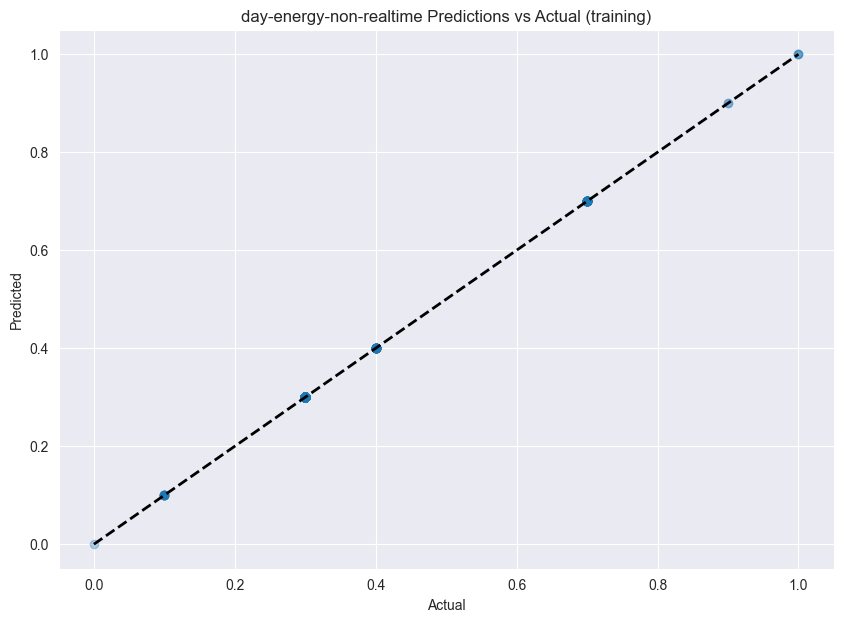

day-energy-non-realtime Validation Set Evaluation:
MAE: 0.00012023866384162881, MSE: 2.2677734489697273e-08, RMSE: 0.00015059128291404277


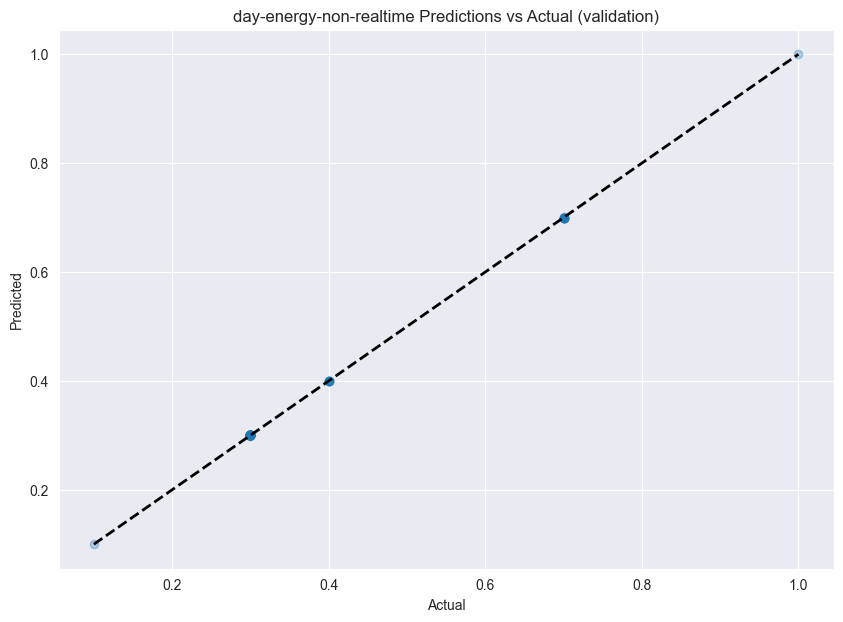

Evaluation for model:  day-energy-realtime
day-energy-realtime Training Set Evaluation:
MAE: 0.0010925849973275387, MSE: 1.9894827874830897e-06, RMSE: 0.001410490264937369


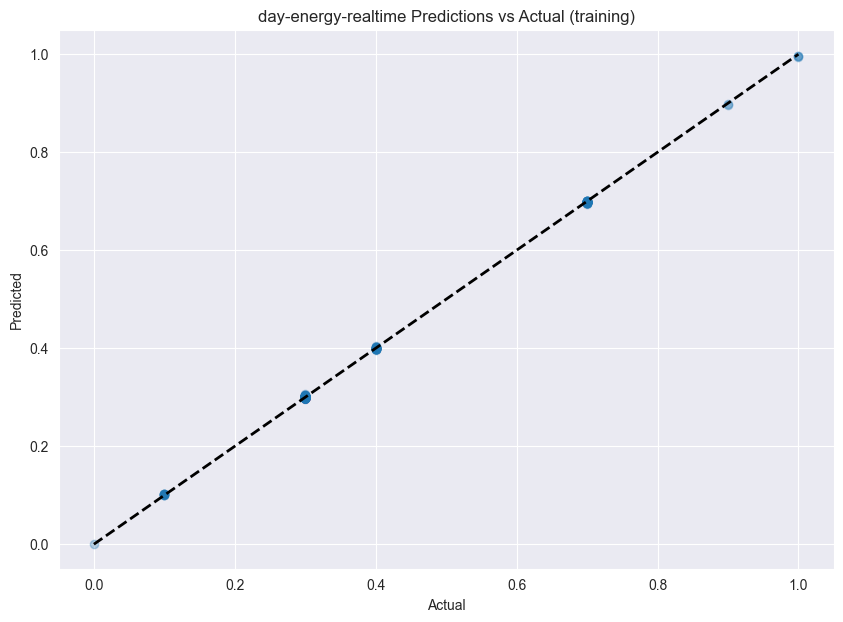

day-energy-realtime Validation Set Evaluation:
MAE: 0.0010900000214328395, MSE: 1.7665647356604477e-06, RMSE: 0.0013291217911314403


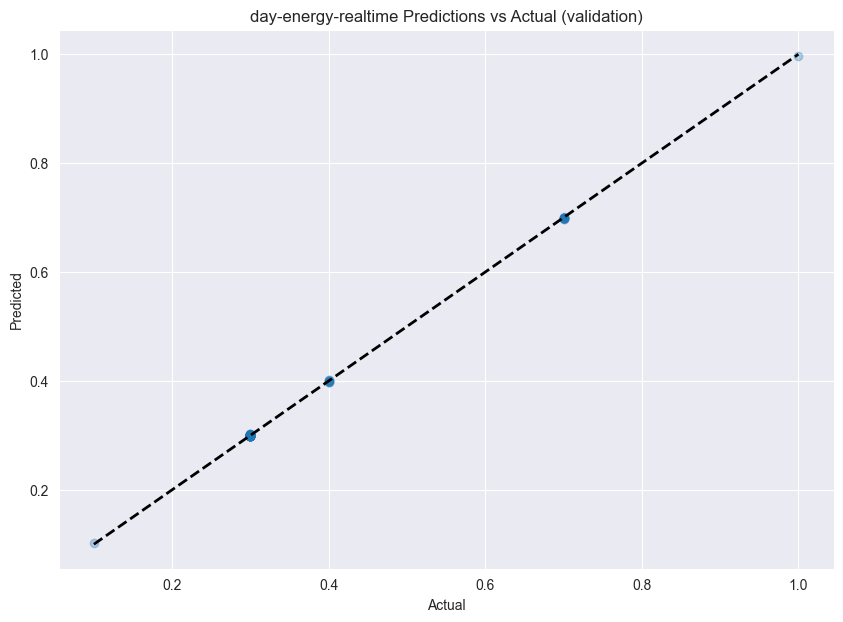

In [44]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(md: ModelAndData, model, X, y):
    # Predict the target values using the trained model
    predictions = model.predict(X)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    print(f"{md.name} Mean Absolute Error (MAE): {mae}")
    print(f"{md.name} Mean Squared Error (MSE): {mse}")
    print(f"{md.name} Root Mean Squared Error (RMSE): {rmse}")

    return mae, mse, rmse

def evaluate_classification_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)
    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_mae, train_mse, train_rmse = evaluate_model(md, model, X_train, y_train)
    
    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_mae, val_mse, val_rmse = evaluate_model(md, model, X_val, y_val)

    val_train = model.predict(X_train)

    train_results_df = pd.DataFrame({
        'Actual': y_train,
        'Predicted': val_train
    })

    cm_train = confusion_matrix(train_results_df['Actual'], train_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (training)')
    plt.show()

    
    # Predict the target values using the trained model
    val_predictions = model.predict(X_val)
    print(val_predictions)
    
    # Create a DataFrame with y_val and the predictions
    val_results_df = pd.DataFrame({
        'Actual': y_val,
        'Predicted': val_predictions
    })

    cm_val = confusion_matrix(val_results_df['Actual'], val_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (validation)')
    plt.show()

def evaluate_regression_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)

    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_predictions = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    print(f"MAE: {train_mae}, MSE: {train_mse}, RMSE: {train_rmse}")

    plt.figure(figsize=(10, 7))
    plt.scatter(y_train, train_predictions, alpha=0.3)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (training)')
    plt.show()

    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_predictions = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = np.sqrt(val_mse)
    print(f"MAE: {val_mae}, MSE: {val_mse}, RMSE: {val_rmse}")

    # Plot the predictions vs actual values for the validation set
    plt.figure(figsize=(10, 7))
    plt.scatter(y_val, val_predictions, alpha=0.3)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (validation)')
    plt.show()
    
for md in models_and_data:
    evaluate_regression_model(md, md.X_train, md.y_train, md.X_val, md.y_val)

## Most useful features

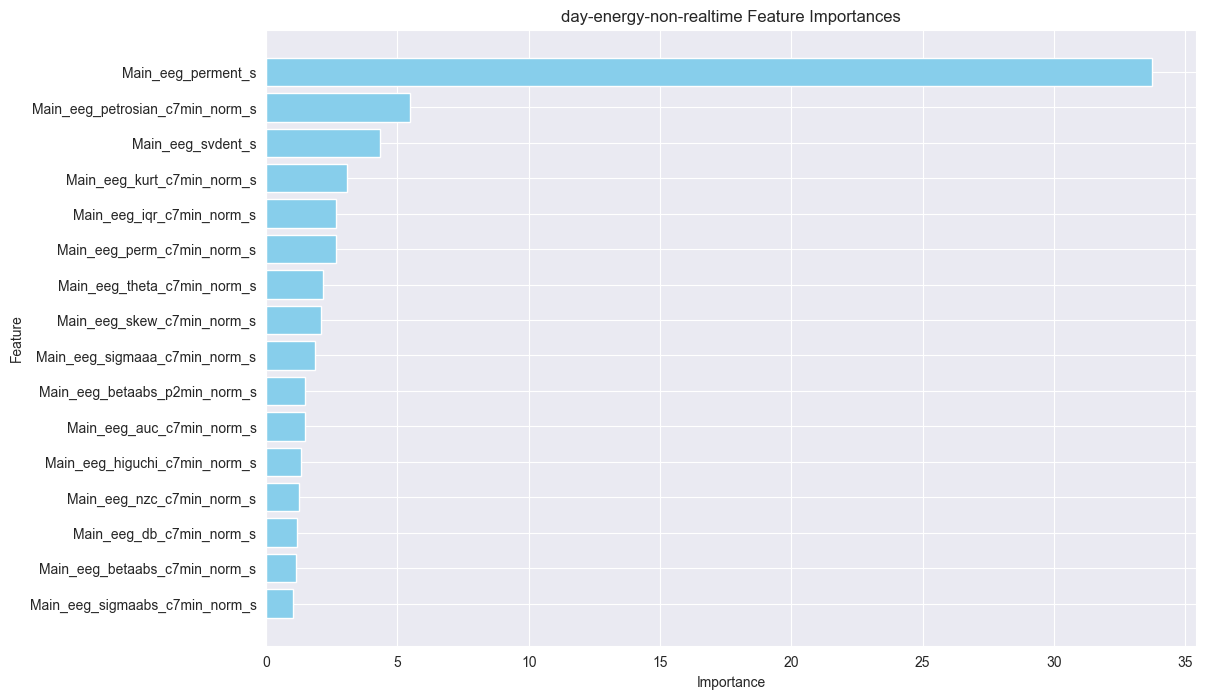

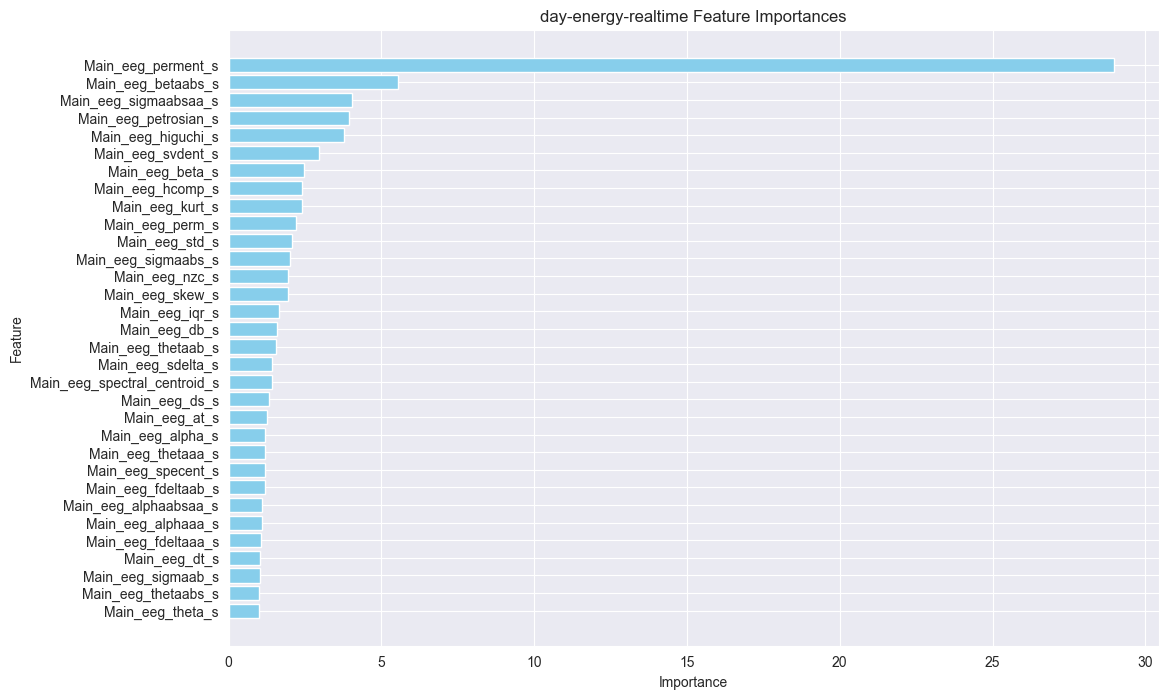

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

def importances(md: ModelAndData):
    # Get feature importances
    feature_importances = md.model.get_feature_importance()
    
    # Create a DataFrame to display the feature importances
    feature_names = md.X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df[importance_df['Importance'] > 1]
    
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(md.name + ' Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

for md in models_and_data:
    importances(md)

# Save model

In [46]:
import dotenv
dotenv.load_dotenv()

import paramiko

# Configure logging
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

def secure_copy_file(local_path, remote_path, hostname, username, password):
    # Create an SSH client
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    
    ssh.connect(hostname, username=username, password=password)

    # Open an SFTP session
    sftp = ssh.open_sftp()

    # Get the size of the file to be transferred
    file_size = os.path.getsize(local_path)

    # Define a callback function to show progress
    with tqdm(total=file_size, unit='B', unit_scale=True, desc=local_path) as pbar:
        def progress_callback(transferred, total):
            pbar.update(transferred - pbar.n)

        # Copy the file with progress callback
        sftp.put(local_path, remote_path, callback=progress_callback)

    # Close the SFTP session and SSH connection
    sftp.close()
    ssh.close()

hostname = os.getenv('SSH_HOST')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD')

for md in models_and_data:
    model_filename = f"{md.name}_catboost_model.cbm"
    md.model.save_model(model_filename)
    secure_copy_file(model_filename, '/home/graham/dev/Brainwave-Models/' + model_filename, hostname, username, password)

print("Copied all files")

day-energy-non-realtime_catboost_model.cbm: 100%|██████████| 2.25M/2.25M [00:01<00:00, 2.25MB/s]
day-energy-realtime_catboost_model.cbm: 100%|██████████| 2.24M/2.24M [00:00<00:00, 2.92MB/s]

Copied all files
